[Link](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_intro_2_python.ipynb)

In [1]:
import anndata
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from sklearn.decomposition import TruncatedSVD 
from scipy import sparse, io

matplotlib.rcParams.update({"font.size": 12})
%config InlineBackend.figure_format = "retina"

In [2]:
# Download reads
!wget https://caltech.box.com/shared/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt -O checksums.txt
!wget https://caltech.box.com/shared/static/w9ww8et5o029s2e3usjzpbq8lpot29rh.gz -O SRR8599150_S1_L001_R1_001.fastq.gz
!wget https://caltech.box.com/shared/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz -O SRR8599150_S1_L001_R2_001.fastq.gz

--2021-02-27 19:30:30--  https://caltech.box.com/shared/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt
Resolving caltech.box.com (caltech.box.com)... 107.152.26.197
Connecting to caltech.box.com (caltech.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt [following]
--2021-02-27 19:30:31--  https://caltech.box.com/public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt [following]
--2021-02-27 19:30:31--  https://caltech.app.box.com/public/static/9u2qk1uqu6py03phooe1ti0kjd9v87pu.txt
Resolving caltech.app.box.com (caltech.app.box.com)... 107.152.26.201
Connecting to caltech.app.box.com (caltech.app.box.com)|107.152.26.201|:443... connected.
HTTP request sent, awaiting response... 3

Connecting to public.boxcloud.com (public.boxcloud.com)|107.152.26.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255171175 (243M) [application/octet-stream]
Saving to: ‘SRR8599150_S1_L001_R1_001.fastq.gz’

SRR8599150_S1_L001_ 100%[===================>] 243.35M  6.47MB/s    in 35s     

2021-02-27 19:31:10 (7.04 MB/s) - ‘SRR8599150_S1_L001_R1_001.fastq.gz’ saved [255171175/255171175]

--2021-02-27 19:31:10--  https://caltech.box.com/shared/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz
Resolving caltech.box.com (caltech.box.com)... 107.152.26.197
Connecting to caltech.box.com (caltech.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz [following]
--2021-02-27 19:31:10--  https://caltech.box.com/public/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Pe

In [3]:
# Verify no corruptions 
!md5sum -c checksums.txt 

SRR8599150_S1_L001_R1_001.fastq.gz: OK
SRR8599150_S1_L001_R2_001.fastq.gz: OK


In [4]:
# Download custom transcriptome indices 
# This downloads a pre-built index for kallisto to use when pseudoaligning the reads
!kb ref -d mouse -i index.idx -g t2g.txt

[2021-02-27 19:32:48,313]    INFO Downloading files for mouse from https://caltech.box.com/shared/static/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz to tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz
[2021-02-27 19:44:46,641]    INFO Extracting files from tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz


## Pseudoalignment and counting

In [5]:
"Generate RNA count matrix of cells (rows) by genes (columns) in H5AD format, which is used for Anndata objects."
!kb count -i index.idx -g t2g.txt -x 10xv2 --h5ad -t 2 \
SRR8599150_S1_L001_R1_001.fastq.gz SRR8599150_S1_L001_R2_001.fastq.gz

[2021-02-27 19:45:04,762]    INFO Generating BUS file from
[2021-02-27 19:45:04,762]    INFO         SRR8599150_S1_L001_R1_001.fastq.gz
[2021-02-27 19:45:04,762]    INFO         SRR8599150_S1_L001_R2_001.fastq.gz
[2021-02-27 19:46:42,073]    INFO Sorting BUS file ./output.bus to tmp/output.s.bus
[2021-02-27 19:46:44,979]    INFO Whitelist not provided
[2021-02-27 19:46:44,979]    INFO Copying pre-packaged 10XV2 whitelist to .
[2021-02-27 19:46:45,037]    INFO Inspecting BUS file tmp/output.s.bus
[2021-02-27 19:46:47,274]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist ./10xv2_whitelist.txt
[2021-02-27 19:47:14,457]    INFO Sorting BUS file tmp/output.s.c.bus to ./output.unfiltered.bus
[2021-02-27 19:47:16,743]    INFO Generating count matrix ./counts_unfiltered/cells_x_genes from BUS file ./output.unfiltered.bus
[2021-02-27 19:47:19,593]    INFO Converting matrix ./counts_unfiltered/cells_x_genes.mtx to h5ad ./counts_unfiltered/adata.h5ad


In [6]:
# Import cells x gene matrix into Anndata matrix 
adata = anndata.read("counts_unfiltered/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 96775 × 55421

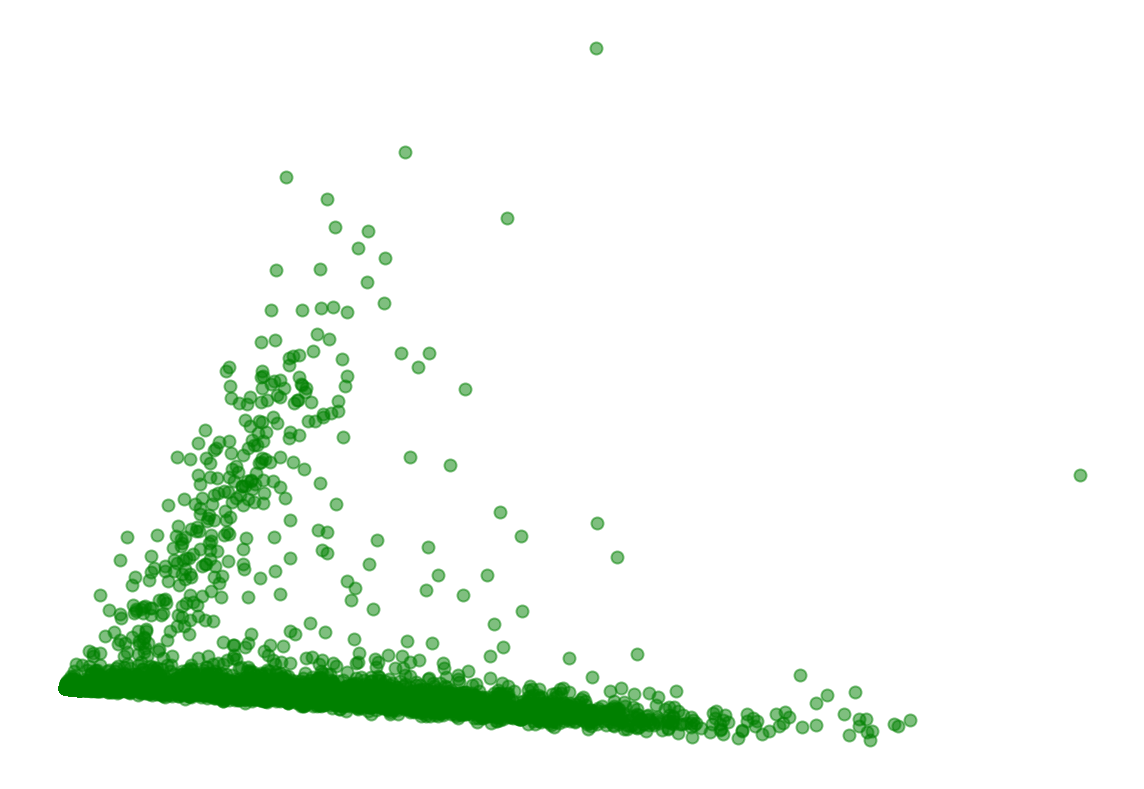

In [7]:
# Cells in 2D PCA 
# SVD 
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(adata.X)
X = tsvd.transform(adata.X)

# Plot cells in 2D projection 
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(X[:,0], X[:,1], alpha=0.5, c="green")

plt.axis("off")
plt.show()